# Inventory Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import torch
import lropt
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":12,
    "font.family": "serif"
})

In [2]:
T = 12
K = 4
c = torch.tensor([(1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5))) for t in range(1, T + 1)])*0.1
p = torch.tensor(c*1.5)
h = torch.tensor(c*1.2)
c = torch.hstack([c,torch.zeros(K-1)])
p = torch.hstack([p,torch.zeros(K-1)])
h = torch.hstack([h,torch.zeros(K-1)])
d_star = np.array([1000 * (1 + 0.5 * np.sin(np.pi * (t - 1) / (T * 0.5))) for t in range(1, T + 1)])
proportion = 0.1
lhs = np.concatenate((np.eye(T), -np.eye(T)), axis=0)    
rhs_upper = (1 + proportion) * d_star
rhs_lower = (-1 + proportion) * d_star
rhs = np.hstack((rhs_upper, rhs_lower))
init_eps = 2
cov = 2000*np.eye(T)
Qmax = 2000
Vmin = -1000
Vmax = 10000
alpha1 = 0.1
alpha2 = 0.2
beta1 = 1
beta2 = 2
init_size = 100
demand_dist = torch.distributions.MultivariateNormal(torch.tensor(d_star),torch.tensor(cov))
torch.manual_seed(100)
sample_val = demand_dist.sample((100,))
# cov = sc.linalg.sqrtm(np.cov(sample_val.T))
init_dist = torch.distributions.Uniform(low = 0, high = 100)
eye_concat = np.eye(T+K-1)
eye_concat[T:,T:] = 0
t_vals = torch.tensor(np.arange(T))
ones = np.ones(T)
zeros = np.zeros(T)
# et_vals = torch.tensor(np.array([np.concatenate([ones[:t+1], zeros[t+1:]]) for t in range(T)]))
def plot_inventory_levels(ax, low_values, mid_values, high_values,random_values,rho):
    ax.plot(range(0, T + 1), low_values, label='Disturbance Lower Bound', color='blue', linestyle='--')
    ax.plot(range(0, T + 1), mid_values, label='Nominal Disturbance', color='green', linestyle='-')
    ax.plot(range(0, T + 1), high_values, label='Disturbance Upper Bound', color='red', linestyle='--')
    ax.plot(range(0, T + 1), random_values, label='Random Trajectory', color='orange', linestyle='--')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Inventory Level')
    ax.set_title(f'Inventory Level Over Time\nrho = {rho}')
    ax.legend()
    ax.grid(True)

In [3]:
d = cp.Variable(T)
cons = [cp.norm(d,2) <= 200]
prob = cp.Problem(objective = cp.Minimize(cp.sum((cov@d + d_star)[5:9])), constraints = cons)
prob.solve()
d.value, (cov@d + d_star).value

(array([  -0.,   -0.,   -0.,   -0.,   -0., -100., -100., -100., -100.,
          -0.,   -0.,   -0.]),
 array([   1000.        ,    1250.        ,    1433.01270189,
           1500.        ,    1433.01270189, -198750.        ,
        -199000.        , -199250.        , -199433.01270189,
            500.        ,     566.98729811,     750.        ]))

## Baseline

In [4]:
def baseline_problem(x_init, cval, pval, hval):
    d = lropt.UncertainParameter(T,uncertainty_set = lropt.Ellipsoidal(p=2,rho=init_eps,c = lhs, d = rhs, a = cov, b = d_star))
    # d = d_star
    q = cp.Variable(T)
    y = cp.Variable(T)
    u = cp.Variable(T)
    z = cp.Variable(T-1)
    w = cp.Variable(T)

    objective = cval@q + cp.sum(y) + cp.sum(u) + cp.sum(z)
    constraints = [0 <= q,
                q <= Qmax]
    for time in range(T):
        constraints +=[Vmin <= x_init + cp.sum(q[:time+1]) - cp.sum(d[:(time+1)]) ]
        constraints +=[x_init + cp.sum(q[:(time+1)]) - cp.sum(d[:(time+1)])<= Vmax]
        constraints += [y[time] >= hval[time]*x_init + hval[time]*cp.sum(q[:(time+1)]) - hval[time]*cp.sum(d[:(time+1)]) ]
        constraints += [y[time] >= -pval[time]*x_init - pval[time]*cp.sum(q[:(time+1)]) + pval[time]*cp.sum(d[:(time+1)]) ]
    constraints += [u >= alpha1*(q -w)]
    constraints += [u >= alpha2*(w-q)]
    constraints += [z >= beta1*(w[1:] - w[:-1])]
    constraints += [z >= beta2*(w[:-1] - w[1:])]
    prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
    prob.solve()
    return prob.objective.value, w.value, q.value, y.value, u.value, z.value


objval1, wval1, qval1, yval1, uval1, zval1 = baseline_problem(x_init = 100, cval=c[:T].detach().numpy(), pval=p[:T].detach().numpy(), hval = h[:T].detach().numpy())

2871.445148162742 2871.445148162742


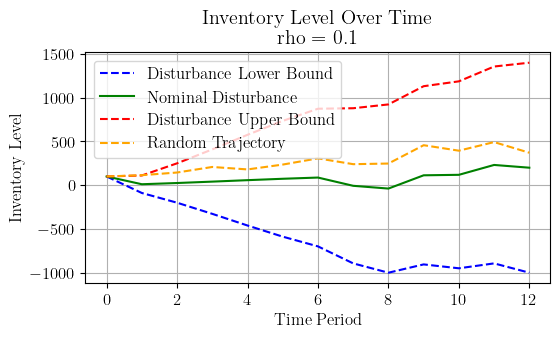

In [5]:
x_init = 100
low_values = [x_init]
mid_values = [x_init]
high_values = [x_init]
random_values = [x_init]
torch.manual_seed(0)
random_traj = demand_dist.sample((5,))[0]
for i in range(1, T + 1):
    low = (cp.sum(qval1[:i]) - cp.sum(rhs_upper[:i]) + x_init).value
    mid = (cp.sum(qval1[:i]) - cp.sum(d_star[:i]) + x_init).value
    high = (cp.sum(qval1[:i]) - cp.sum(-rhs_lower[:i]) + x_init).value
    traj = (cp.sum(qval1[:i]) - cp.sum(random_traj[:i]) + x_init).value
    low_values.append(low)
    mid_values.append(mid)
    high_values.append(high)
    random_values.append(traj)
fig, ax = plt.subplots(figsize = (6,3))
plot_inventory_levels(ax, low_values, mid_values, high_values,random_values, 0.1)
print(objval1-sum(zval1),(c[:T].detach().numpy()@(qval1) + cp.sum(yval1) + cp.sum(uval1)).value)

In [8]:
def baseline_problem_aro(init_val, cval, pval, hval):
    d = lropt.UncertainParameter(T,uncertainty_set = lropt.Ellipsoidal(p=2,rho=init_eps,c = lhs, d = rhs, a = cov, b = d_star))
    # d = d_star
    q = cp.Variable(T)
    y = cp.Variable(T)
    u = cp.Variable(T)
    z = cp.Variable(T-1)
    w = cp.Variable(T)
    u_var = cp.Variable((T,T))
    y_var = cp.Variable((T,T))
    q_var = cp.Variable((T,T))
    C = cp.Variable()
    x_init = cp.Parameter()
    x_init.value = init_val

    objective = C
    constraints = [cval@(q + q_var@d) + cp.sum(y + y_var@d) + cp.sum(u + u_var@d) + cp.sum(z) <= C,
                0 <= q+ q_var@d,
                q+q_var@d <= Qmax]
    # constraints += [y_var == 0, u_var==0]
    for time in range(T):
        for time2 in range(time,T):
            constraints += [q_var[time,time2] == 0]

    for time in range(T):
        constraints +=[Vmin <= x_init + cp.sum((q+q_var@d)[:time+1]) - cp.sum(d[:(time+1)]) ]
        constraints +=[x_init + cp.sum((q+q_var@d)[:(time+1)]) - cp.sum(d[:(time+1)])<= Vmax]
        constraints += [(y + y_var@d)[time] >= hval[time]*x_init + hval[time]*cp.sum((q+q_var@d)[:(time+1)]) - hval[time]*cp.sum(d[:(time+1)]) ]
        constraints += [(y + y_var@d)[time] >= -pval[time]*x_init - pval[time]*cp.sum((q+q_var@d)[:(time+1)]) + pval[time]*cp.sum(d[:(time+1)]) ]
    constraints += [u + u_var@d >= alpha1*(q+q_var@d -w)]
    constraints += [u + u_var@d >= alpha2*(w-q-q_var@d)]
    constraints += [z >= beta1*(w[1:] - w[:-1])]
    constraints += [z >= beta2*(w[:-1] - w[1:])]
    prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
    return prob, x_init, w,q,q_var,y,y_var,u,u_var,z

baseline_prob, x_init, w_baseline,q,q_var,y,y_var,u,u_var,z = baseline_problem_aro(init_val = 100, cval=c[:T].detach().numpy(), pval=p[:T].detach().numpy(), hval = h[:T].detach().numpy())
baseline_prob.solve()
objval, wval, qval, qmat, yval, ymat, uval, umat, zval = baseline_prob.objective.value, w_baseline.value, q.value, q_var.value, y.value, y_var.value, u.value, u_var.value, z.value

2229.509679417104 2082.9896487335463


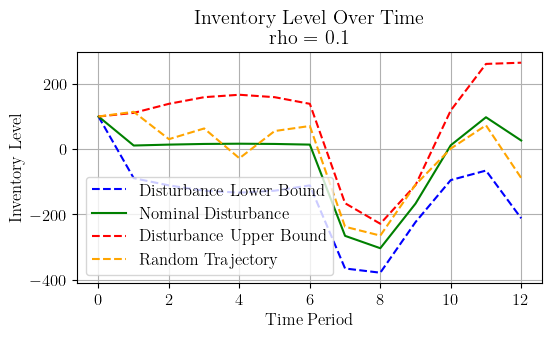

In [7]:
#if y and u are not adjustable
low_values = [x_init.value]
mid_values = [x_init.value]
high_values = [x_init.value]
random_values = [x_init.value]
for i in range(1, T + 1):
    low = (cp.sum((qval+qmat@rhs_upper)[:i]) - cp.sum(rhs_upper[:i]) + x_init).value
    mid = (cp.sum((qval+qmat@d_star)[:i]) - cp.sum(d_star[:i]) + x_init).value
    high = (cp.sum((qval-qmat@rhs_lower)[:i]) - cp.sum(-rhs_lower[:i]) + x_init).value
    traj = (cp.sum((qval+qmat@(random_traj.detach().numpy()))[:i]) - cp.sum(random_traj.detach().numpy()[:i]) + x_init).value
    low_values.append(low)
    mid_values.append(mid)
    high_values.append(high)
    random_values.append(traj)
fig, ax = plt.subplots(figsize = (6,3))
plot_inventory_levels(ax, low_values, mid_values, high_values, random_values, 0.1)
print(objval-sum(zval),(c[:T].detach().numpy()@(q + q_var@random_traj) + cp.sum(y + y_var@random_traj) + cp.sum(u + u_var@random_traj)).value )

2033.5647298991598 2031.589705632651


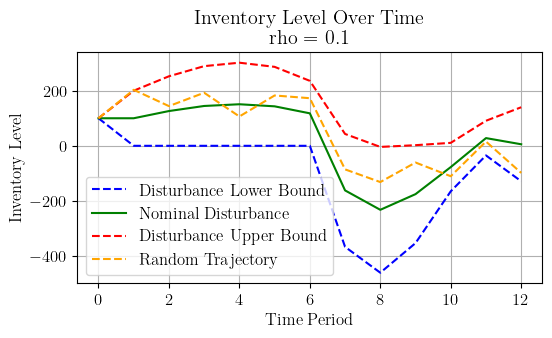

In [9]:
# x_init.value = 100
low_values = [x_init.value]
mid_values = [x_init.value]
high_values = [x_init.value]
random_values = [x_init.value]
for i in range(1, T + 1):
    low = (cp.sum((qval+qmat@rhs_upper)[:i]) - cp.sum(rhs_upper[:i]) + x_init).value
    mid = (cp.sum((qval+qmat@d_star)[:i]) - cp.sum(d_star[:i]) + x_init).value
    high = (cp.sum((qval-qmat@rhs_lower)[:i]) - cp.sum(-rhs_lower[:i]) + x_init).value
    traj = (cp.sum((qval+qmat@(random_traj.detach().numpy()))[:i]) - cp.sum(random_traj.detach().numpy()[:i]) + x_init).value
    low_values.append(low)
    mid_values.append(mid)
    high_values.append(high)
    random_values.append(traj)
fig, ax = plt.subplots(figsize = (6,3))
plot_inventory_levels(ax, low_values, mid_values, high_values, random_values, 0.1)
print(objval-sum(zval),(c[:T].detach().numpy()@(q + q_var@random_traj) + cp.sum(y + y_var@random_traj) + cp.sum(u + u_var@random_traj)).value)

In [10]:
wval.round(3) - (qval + qmat@d_star).round(3),np.sum(d_star),np.sum(qval + qmat@d_star),np.sum(wval), np.sum(yval + ymat@d_star), np.sum(uval + umat@d_star),np.sum(zval)

(array([-268.832, -545.003, -720.258, -775.072, -694.32 , -493.422,
          10.958,   51.615,  107.282,  132.946,   58.971,    3.569]),
 12000.0,
 11905.583664135256,
 8774.018464166065,
 249.01589907520787,
 451.2638312776771,
 2.2294591908438568e-10)

## Multistage

In [22]:
d = lropt.UncertainParameter(T,uncertainty_set = lropt.Ellipsoidal(p=2,rho=1,c = lhs, d = rhs, data = sample_val.detach().numpy()))
if K>1:
    totnum = (3*K+7)*(T+K-1)+2*K + 1
    y_endind = (6*(T+K-1)+2*K+1)
else:
    totnum = (3*K+7)*(T+K-1)+2*K + 1+1
    y_endind = (6*(T+K-1)+2*K+1)+1
# np.zeros((init_size,totnum))
xall = lropt.Parameter(totnum, data= np.zeros((100,totnum)))  
offset = 0
if K==1:
    offset = 1
x_hat = xall[:(T+K-1)+offset]
q_hat = xall[(T+K-1)+offset:2*(T+K-1)+offset]
d_hat =  xall[(2*(T+K-1)+offset):(3*(T+K-1)+offset)]
y_hat = xall[(3*(T+K-1)+offset):(4*(T+K-1)+offset)]
u_hat = xall[(4*(T+K-1)+offset):(5*(T+K-1)+offset)]
p_xhat = xall[(5*(T+K-1)+offset):((5*(T+K-1)+K)+offset)]
h_xhat = xall[((5*(T+K-1)+K)+offset):((5*(T+K-1)+2*K)+offset)]
w = xall[(5*(T+K-1)+2*K+offset):(6*(T+K-1)+2*K+offset)]
t = xall[(6*(T+K-1)+2*K+offset):(6*(T+K-1)+2*K+1+offset)]

# e_x = xall[(3*(T+K-1)+2*K+T+1):(4*(T+K-1)+2*K+T+1)]
# e_t = xall[(4*(T+K-1)+2*K+T+1):(5*(T+K-1)+2*K+T+1)]
e_ind = xall[(6*(T+K-1)+2*K+1+offset):((K+6)*(T+K-1)+2*K+1+offset)]
p_ind = xall[((K+6)*(T+K-1)+2*K+1+offset):((2*K+6)*(T+K-1)+2*K+1+offset)]
h_ind =  xall[((2*K+6)*(T+K-1)+2*K+1+offset):((3*K+6)*(T+K-1)+2*K+1+offset)]
c_ind = xall[((3*K+6)*(T+K-1)+2*K+1+offset):]

# e_x = cp.Parameter(T+K-1) # 0 to t
# e_t = cp.Parameter(T+K-1) #0...t-1
# e_ind = cp.Parameter(K*(T+K-1)) #t,t+1,...t+K
# p_ind = cp.Parameter(K*(T+K-1)) #t*(t), pt+1*(t,t+1), pt+2*(t,t+1,t+2),..
# h_ind = cp.Parameter(K*(T+K-1)) #h*(t,t+1,...t+K)

# I_ex = cp.diag(e_x)
# I_et = cp.diag(e_t)
e_inds = cp.sum([e_ind[j*(T+K-1):((j+1)*(T+K-1))] for j in range(K)]) #t...t+K
I_inds = cp.diag(e_inds)

uall = cp.Variable(3*(T+K-1)+1)
q = uall[:(T+K-1)]
y = uall[(T+K-1):2*(T+K-1)]
u = uall[2*(T+K-1):3*(T+K-1)]
C = uall[3*(T+K-1):]

wvar = cp.Variable(T+K-1)
e_indvar = cp.Variable(K*(T+K-1))
h_indvar = cp.Variable(K*(T+K-1))
p_indvar = cp.Variable(K*(T+K-1))


objective = C**2
constraints = [c_ind@q + e_inds@y + e_inds@u <= C]
constraints += [0 <= q,
                q <= Qmax]


if K > 1:
    constraints += [q[T:] == 0, y[T:]==0,u[T:]==0]
constraints += [d >= 0]
for i in range(K):
    constraints += [Vmin <= x_hat[0] + cp.sum(q_hat) + cp.sum([e_ind[j*(T+K-1):((j+1)*(T+K-1))] for j in range(i+1)])@q - cp.sum(d_hat) - cp.sum([e_indvar[j*(T+K-1):((j+1)*(T+K-1))] for j in range(i+1)])[:T]@d] 

    constraints += [x_hat[0] + cp.sum(q_hat) + cp.sum([e_ind[j*(T+K-1):((j+1)*(T+K-1))] for j in range(i+1)])@q - cp.sum(d_hat) - cp.sum([e_indvar[j*(T+K-1):((j+1)*(T+K-1))] for j in range(i+1)])[:T]@d <= Vmax]
    
    constraints += [e_ind[i*(T+K-1):((i+1)*(T+K-1))]@y >= h_xhat[i] + h_ind[i*(T+K-1):((i+1)*(T+K-1))]@q - h_indvar[i*(T+K-1):((i+1)*(T+K-1))][:T]@d ]

    constraints += [e_ind[i*(T+K-1):((i+1)*(T+K-1))]@y >= -p_xhat[i] - p_ind[i*(T+K-1):((i+1)*(T+K-1))]@q + p_indvar[i*(T+K-1):((i+1)*(T+K-1))][:T]@d ]

constraints += [I_inds@u >= alpha1*(I_inds@q - I_inds@wvar),
                I_inds@u >= alpha2*(-I_inds@q + I_inds@wvar)]
constraints += [e_ind == e_indvar, h_ind ==h_indvar, p_ind == p_indvar, w == wvar]
                                                                         
prob = lropt.RobustProblem(cp.Minimize(objective), constraints)
trainer = lropt.Trainer(prob)
policy = trainer.create_cvxpylayer(variables = [uall])

In [278]:
# for times in range(T):
#     print(times)
#     prob.solve(verbose=True, solver = cp.CLARABEL)
#     newx = simulator.simulate(torch.tensor(xall.value).repeat(2,1),torch.tensor(uall.value).repeat(2,1))
#     xall.value = newx[0].detach().numpy()

In [23]:
class InvSimulator(lropt.Simulator):
    def simulate(self, x, u):
        assert x.shape[0] == u.shape[0]
        batch_size = x.shape[0]
        t = int(x[0,(6*(T+K-1)+2*K+offset):(6*(T+K-1)+2*K+1+offset)])
        demand = demand_dist.sample((batch_size,))[:,t]
        x_new = x[:,:(T+K-1)+offset]
        x_orig = x[:,t]
        q_new = x[:,((T+K-1)+offset):(2*(T+K-1)+offset)]
        q_newest = u[:,t]
        q_new[:,t] = q_newest
        d_new = x[:,(2*(T+K-1)+offset):(3*(T+K-1)+offset)]
        d_new[:,t] = demand
        x_new[:,t+1] = x_orig + q_newest - demand
        y_new = x[:,(3*(T+K-1)+offset):(4*(T+K-1)+offset)]
        y_newest = u[:,(T+K-1)+t]
        y_new[:,t] = y_newest
        u_new = x[:,(4*(T+K-1)+offset):(5*(T+K-1)+offset)]
        u_newest = u[:,2*(T+K-1)+t]
        u_new[:,t] = u_newest
        t_new = (torch.tensor(t)+1).repeat(batch_size,1)
        t = T-2 if t==T-1 else t
        p_x = torch.vstack([p[t+i+1]*x_new[:,t+1] for i in range(K)]).T
        h_x = torch.vstack([h[t+i+1]*x_new[:,t+1] for i in range(K)]).T
        w_new = x[:,(5*(T+K-1)+2*K+offset):(6*(T+K-1)+2*K+offset)]
        e_new = eye_concat[(t+1):(t+1+K)].flatten()
        p_new = torch.hstack([p[t+j+1]*np.sum([e_new[i*(T+K-1):(i+1)*(T+K-1)] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1)
        h_new = torch.hstack([h[t+j+1]*np.sum([e_new[i*(T+K-1):(i+1)*(T+K-1)] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1)
        c_new = (c*np.sum([e_new[i*(T+K-1):(i+1)*(T+K-1)] for i in range(K)],axis=0)).repeat((batch_size,1))
        e_new = torch.tensor(e_new).repeat(batch_size,1)
        x = torch.cat([x_new,q_new,d_new,y_new,u_new,p_x,h_x,w_new,t_new,e_new,p_new,h_new,c_new],axis=1)
        # print(x)
        return x

    def stage_cost_eval(self,x,u):
        assert x.shape[0] == u.shape[0]
        batch_size = x.shape[0]
        t = int(x[0,(6*(T+K-1)+2*K+offset):(6*(T+K-1)+2*K+1+offset)])
        if t == T:
            q_hat = x[:,((T+K-1)+offset):(2*(T+K-1)+offset)]
            y_hat = x[:,(3*(T+K-1)+offset):(4*(T+K-1)+offset)]
            u_hat = x[:,(4*(T+K-1)+offset):(5*(T+K-1)+offset)]
            return T*(torch.sum(c.repeat((batch_size,1))*q_hat,axis=1) + torch.sum(y_hat,axis=1)+torch.sum(u_hat,axis=1))
        else:
            return np.zeros(batch_size)

    def stage_cost(self,x,u):
        assert x.shape[0] == u.shape[0]
        batch_size = x.shape[0]
        q_hat = x[:,((T+K-1)+offset):(2*(T+K-1)+offset)]
        y_hat = x[:,(3*(T+K-1)+offset):(4*(T+K-1)+offset)]
        u_hat = x[:,(4*(T+K-1)+offset):(5*(T+K-1)+offset)]
        return (torch.sum(c.repeat((batch_size,1))*q_hat,axis=1) + torch.sum(y_hat,axis=1)+torch.sum(u_hat,axis=1))


    def constraint_cost(self,x,u,alpha):
        eta = 0.05
        assert x.shape[0] == u.shape[0]
        batch_size = x.shape[0]
        t = int(x[0,(6*(T+K-1)+2*K+offset):(6*(T+K-1)+2*K+1+offset)])
        x_hat = x[:,t]
        y_hat = x[:,3*(T+K-1)+t-1+offset]
        u_hat = x[:,4*(T+K-1)+t-1+offset]
        cvar_term =(1/eta)*torch.max(torch.max(-p[t-1]*x_hat, h[t-1]*x_hat) - y_hat - alpha,torch.zeros(batch_size)) + alpha
        return (cvar_term + 0.01)

    def init_state(self,batch_size, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        t = 0
        if K>1:
            x_new = torch.zeros((batch_size,T+K-1))
        else: 
            x_new = torch.zeros((batch_size,T+K))
        x_orig = 100*torch.ones((batch_size,))
        # w_list = []
        # x_orig = init_dist.sample((batch_size,))
        # for j in range(batch_size):
        #     x_init.value = x_orig[j].detach().numpy()
        #     baseline_prob.solve(solver = cp.CLARABEL)
        #     w_list.append(torch.tensor(w_baseline.value))
        # w_new = torch.stack(w_list)
        w_new = torch.tensor(w_baseline.value).repeat((batch_size,1))
        w_zeros = torch.zeros((batch_size,K-1))
        x_new[:,0] = x_orig
        q_new = torch.zeros((batch_size,T+K-1))
        d_new = torch.zeros((batch_size,T+K-1))
        y_new = torch.zeros((batch_size,T+K-1))
        u_new = torch.zeros((batch_size,T+K-1))
        p_x = torch.vstack([p[t+i]*x_new[:,t] for i in range(K)]).T
        h_x = torch.vstack([h[t+i]*x_new[:,t] for i in range(K)]).T
        
        t_new = (torch.tensor(t)).repeat(batch_size,1)
        e_new = eye_concat[(t):(t+K)].flatten()
        p_new = torch.hstack([p[t+j]*np.sum([e_new[i*(T+K-1):(i+1)*(T+K-1)] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1)
        h_new = torch.hstack([h[t+j]*np.sum([e_new[i*(T+K-1):(i+1)*(T+K-1)] for i in range(j+1)],axis=0) for j in range(K)]).repeat(batch_size,1)
        c_new = (c*np.sum([e_new[i*(T+K-1):(i+1)*(T+K-1)] for i in range(K)],axis=0)).repeat((batch_size,1))
        e_new = torch.tensor(e_new).repeat(batch_size,1)
        x = torch.cat([x_new,q_new,d_new,y_new,u_new,p_x,h_x,w_new,w_zeros,t_new,e_new,p_new,h_new,c_new],axis=1)
        return x
simulator = InvSimulator()

In [24]:
# Perform training
epochs = 2
batch_size = 5
test_batch_size = 5
lr = 1
# init_x = simulator.init_state(seed = 0, batch_size = 100)
init_a = cov
init_b = d_star
val_costs1, val_costs_constr1, \
  paramvals, x_base1, u_base1, \
    train_vals1, train_cons1 = trainer.multistage_train(simulator, 
                                                       policy = policy, 
                         time_horizon = T, epochs = epochs, 
                         batch_size = batch_size, init_eps=init_eps, seed=0,
                          init_a = init_a, init_b = init_b,
                          optimizer = "SGD",lr= lr, momentum = 0, init_alpha = 0.0, scheduler = True, lr_step_size = 30, lr_gamma = 0.9, contextual = False, test_batch_size = test_batch_size,y_endind = y_endind)

Baseline cost:  2001.885694622133
epoch 0, valid 1.9923e+03, vio 9.6289e+00


In [25]:
trainer._eps_tch,trainer._alpha, trainer._a_tch, trainer._b_tch
# trainer._linear.weight.data, trainer._linear.bias.data

(tensor(-0.0017, dtype=torch.float64),
 tensor(-1.1921e-07),
 tensor([[-2.0191e-08, -2.6033e-08, -2.9686e-08, -3.1546e-08, -3.0232e-08,
          -2.6746e-08, -2.0690e-08, -1.4495e-08, -1.1460e-08, -1.0652e-08,
          -1.1449e-08, -7.1855e-09],
         [-2.5392e-08, -3.2610e-08, -3.7211e-08, -3.9565e-08, -3.7932e-08,
          -3.3621e-08, -2.6008e-08, -1.8225e-08, -1.4395e-08, -1.3371e-08,
          -1.4380e-08, -9.1551e-09],
         [-2.9361e-08, -3.7726e-08, -4.2898e-08, -4.5634e-08, -4.3762e-08,
          -3.8795e-08, -3.0064e-08, -2.1079e-08, -1.6636e-08, -1.5443e-08,
          -1.6620e-08, -1.0664e-08],
         [-3.1916e-08, -4.0997e-08, -4.6670e-08, -4.9355e-08, -4.7343e-08,
          -4.1957e-08, -3.2582e-08, -2.2944e-08, -1.8071e-08, -1.6735e-08,
          -1.8054e-08, -1.1542e-08],
         [-3.0724e-08, -3.9482e-08, -4.4968e-08, -4.7576e-08, -4.5530e-08,
          -4.0360e-08, -3.1347e-08, -2.2084e-08, -1.7394e-08, -1.6101e-08,
          -1.7377e-08, -1.0945e-08],
    

In [21]:
trainer._eps_tch,trainer._alpha, trainer._a_tch, trainer._b_tch
# trainer._linear.weight.data, trainer._linear.bias.data

(tensor(-0.0002, dtype=torch.float64),
 tensor(-1.1921e-07),
 tensor([[ 2.9742e-12, -4.4408e-13, -7.5718e-13, -1.8861e-12, -1.2933e-12,
          -1.0294e-12, -6.1929e-13, -4.2057e-13, -2.7464e-13, -2.0768e-13,
          -2.2250e-13, -2.3917e-13],
         [-2.3587e-12,  2.1630e-12, -3.5322e-12, -5.3695e-12, -4.6688e-12,
          -3.8614e-12, -2.8344e-12, -2.0702e-12, -1.5117e-12, -1.2900e-12,
          -1.4470e-12, -1.8451e-12],
         [-3.8348e-12, -4.4280e-12,  1.8866e-12, -6.8728e-12, -6.6332e-12,
          -5.8851e-12, -4.2364e-12, -3.1139e-12, -2.2925e-12, -1.9723e-12,
          -2.2180e-12, -2.8552e-12],
         [-4.4876e-12, -5.4879e-12, -5.7048e-12,  8.5170e-12, -1.6322e-12,
          -4.2357e-12, -4.4534e-12, -3.6281e-12, -2.6783e-12, -2.3102e-12,
          -2.6007e-12, -3.3576e-12],
         [-3.0409e-12, -3.8277e-12, -4.2488e-12, -1.6161e-13,  7.5393e-12,
          -1.1913e-12, -2.3703e-12, -2.5588e-12, -1.9073e-12, -1.6324e-12,
          -1.8328e-12, -2.3456e-12],
    

In [292]:
trainer._b_tch.data-init_b

tensor([-7.1293e-06, -1.2084e-05, -1.1999e-05, -1.0818e-05, -9.0785e-06,
        -7.3665e-06, -5.8452e-06, -4.2311e-06, -3.2064e-06, -2.7586e-06,
        -3.0138e-06, -4.1099e-06], dtype=torch.float64)

In [295]:
sum(abs(trainer._a_tch.data-init_a))

tensor([9.4243e-07, 1.8696e-06, 1.5206e-06, 6.9860e-06, 1.1159e-06, 7.7753e-07,
        6.8802e-07, 5.8292e-07, 4.3917e-07, 3.8942e-07, 4.4897e-07, 5.9484e-07],
       dtype=torch.float64)

In [288]:
def plot_iters(val_costs1,val_costs_constr1,epochs):
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.plot(np.arange(0,epochs,20), (np.array(val_costs1)), c='k', label=r"$\hat{J}(\theta)$")
    ax1 = ax.twinx()
    ax1.plot(np.arange(0,epochs,20),(np.array(val_costs_constr1)), color = 'red', 
    linestyle = "-", label = r"$\hat{V}(\theta)$")
    ax1.hlines(y=0,xmin=0,xmax=epochs, color= "black", linestyle = "--", label = "0")
    # plt.ylim([-0.03,0.015])
    ax.set_xlabel('iteration')
    ax.set_ylabel('cost')
    fig.tight_layout()
    plt.legend(fontsize = 15, bbox_to_anchor=(1, 0.8))
    ax.legend(fontsize = 15)
    plt.savefig("port_iters.pdf", bbox_inches='tight')
    plt.show()
def plot_states(x_base1,indval=0):
    plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":12,
    "font.family": "serif"
    })
    fig,ax= plt.subplots(1,4, figsize = (10,2.5))
    for i in range(5):
        ax[0].plot(x_base1[indval][0][-1][i][:T+1]) # x
        ax[1].plot(x_base1[indval][0][-1][i][(T+K-1+offset):(2*T+K-1+offset)]) # q
        ax[2].plot(x_base1[indval][0][-1][i][(3*(T+K-1)+offset):3*(T+K-1)+T+offset]) # y
        ax[3].plot(x_base1[indval][0][-1][i][(4*(T+K-1)+offset):4*(T+K-1)+T+offset]) # u
    ax[0].plot(random_values, color = 'black')
    ax[1].plot(qval+qmat@random_traj.detach().numpy(), color = 'black',label="ARO")
    ax[2].plot(yval+ymat@random_traj.detach().numpy(), color = 'black')
    ax[3].plot(uval+umat@random_traj.detach().numpy(), color = 'black')
    for i in range(4):
        ax[i].grid(True)
        ax[i].set_xlabel('Time Period')
    ax[0].set_title('Inventory Level')
    ax[1].set_title('Amount Ordered')
    ax[2].set_title('Holding/Shortage Cost')
    ax[3].set_title('Commitment Deviation Cost')
    fig.tight_layout()
    ax[1].legend()
    plt.show()

### K=4

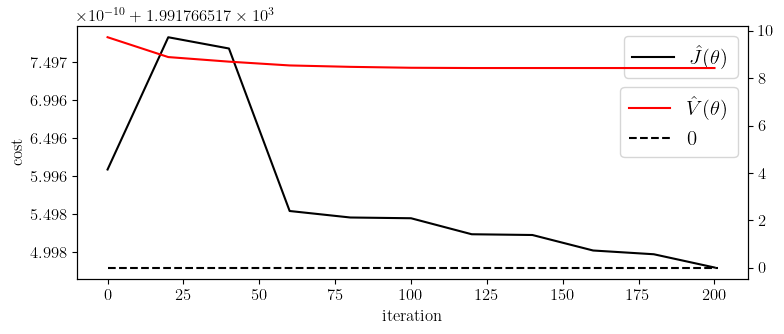

In [211]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.9/30, init 0.05,5/5 batch, eps2, cvar 1,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=4

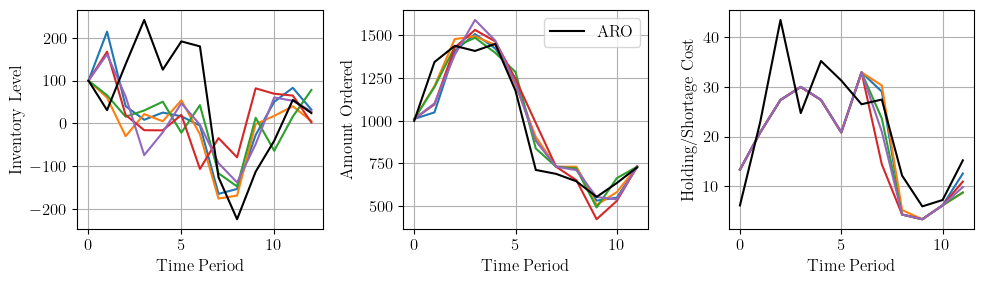

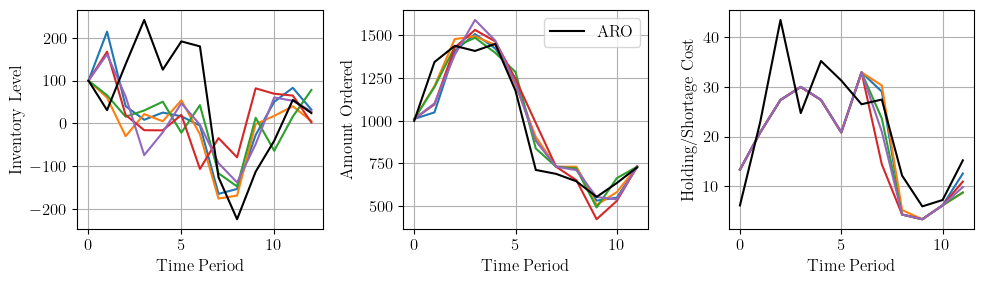

In [212]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

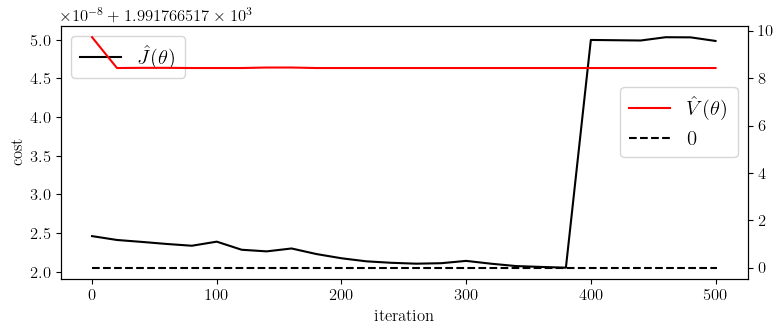

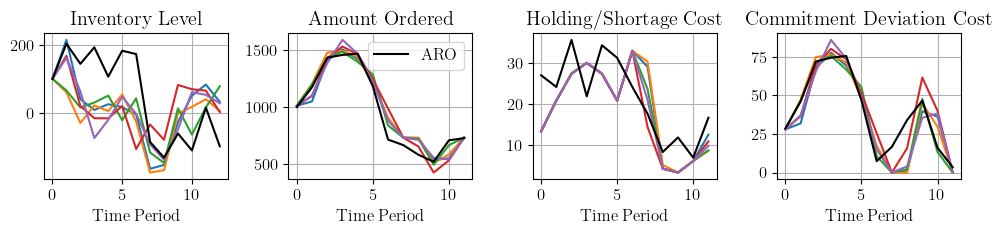

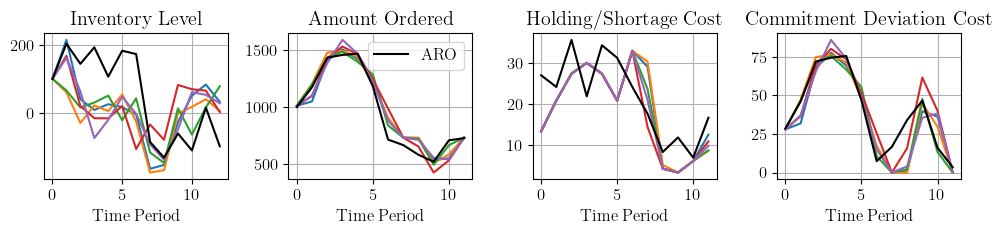

In [283]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.9/30, init 1,5/5 batch, eps2, cvar 1,0.01, seed 0, clarabel, noncontext, p=c1.5 h=c1.2, T=12,K=4
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

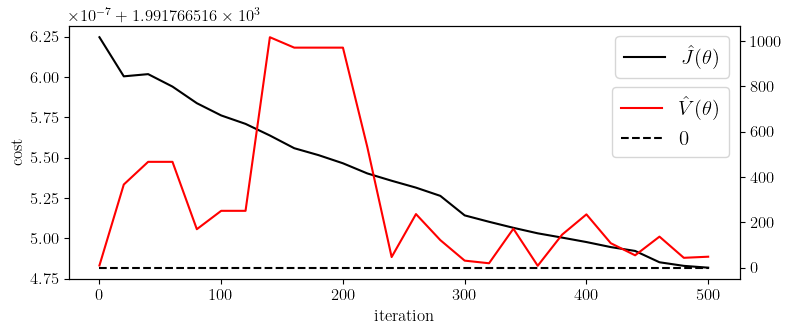

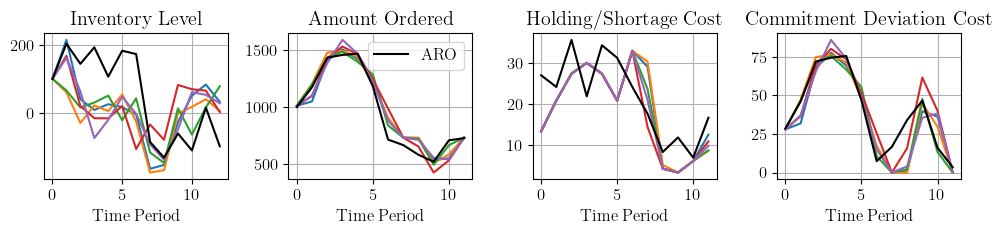

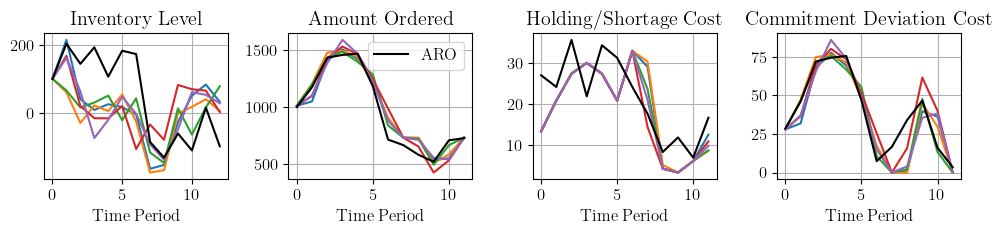

In [289]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.9/30, init 1,5/5 batch, eps2, cvar 1,0.01, seed 0, clarabel, noncontext, p=c1.5 h=c1.2, T=12,K=4
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

### K=1

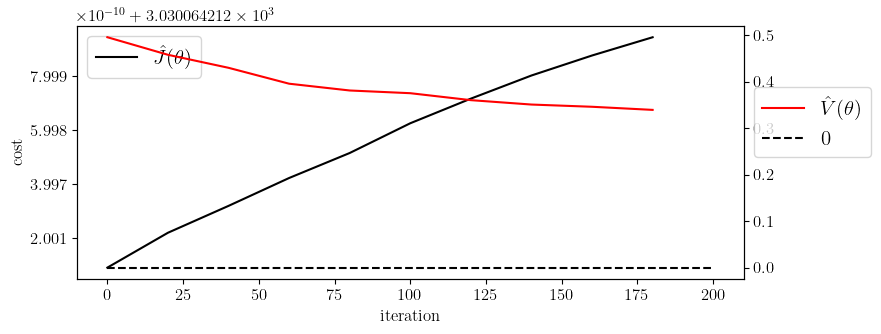

In [201]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.9/20, init 0.01,5/5 batch, eps2, cvar 1,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=1

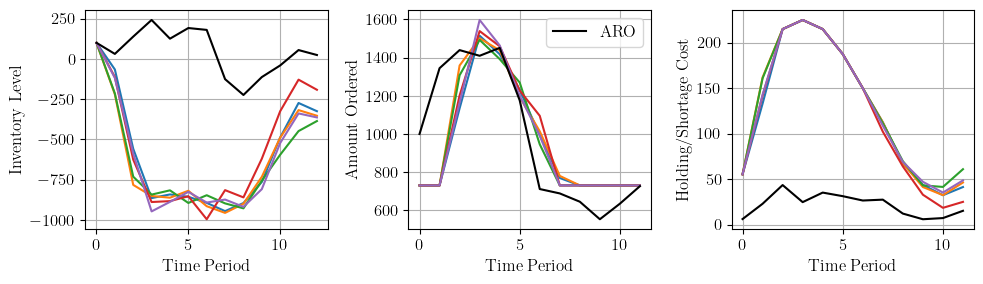

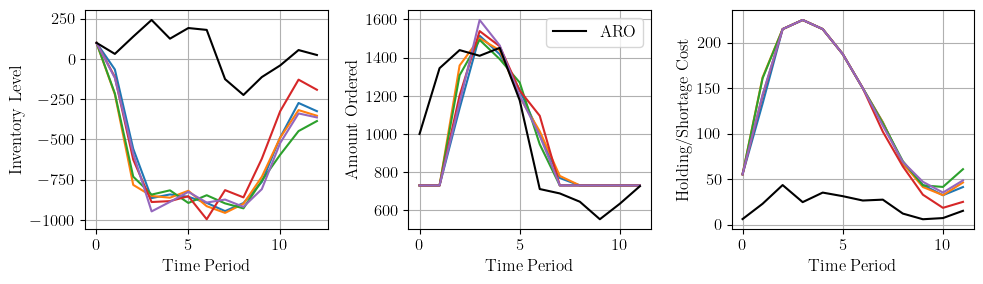

In [202]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)

### K=12

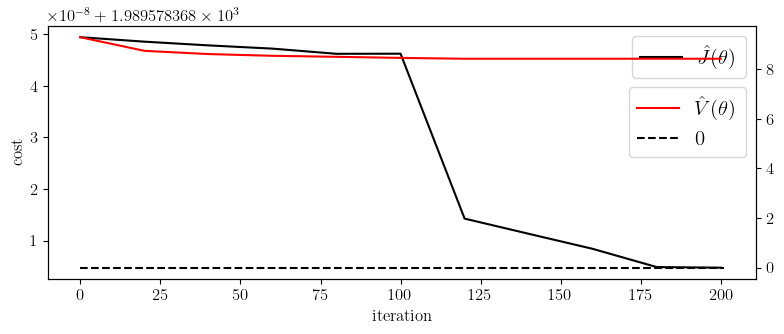

In [221]:
plot_iters(val_costs1,val_costs_constr1,epochs)
#0.9/30, init 0.05,5/5 batch, eps2, cvar 1,0.01, seed 0, clarabel, context, p=c1.5 h=c1.2, T=12,K=12

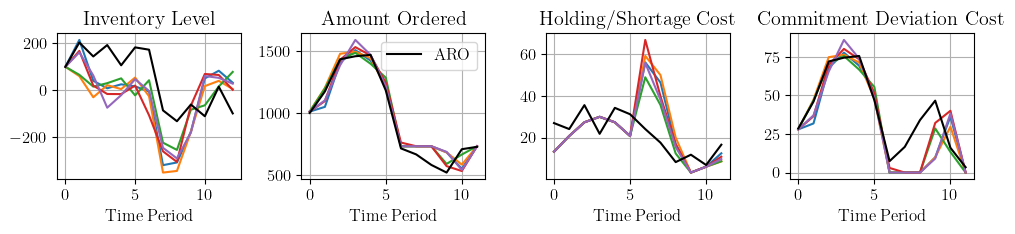

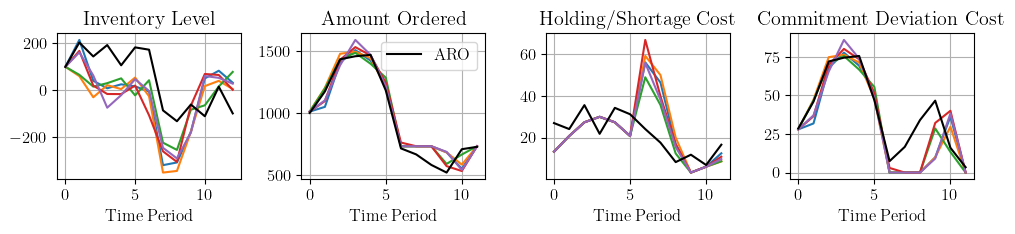

In [269]:
plot_states(x_base1,indval=0)
plot_states(x_base1,indval=-1)